# Выпускной проект

**Название проекта:**

**Телекоммуникации: Построение модели оттока клиентов**


**Описание проекта:**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Задача проекта:**

Научиться прогнозировать отток клиентов, чтобы можно было их удержать путем маркетинговых решений (промокоды, скидки и т.д)

Для этого необходимо решить задачу классификации и построить модель с метрикой ROC-AUC > 0.85, которая будет классифицировать клиентов на лояльных и собирающихся уйти (зная последних - бизнес вовремя сможет предложить им новые условия и тем самым оставить клиента). Почему это важно - оставить клиента - потому что на момент задачи (1 февраля 2020 года) почти все люди уже имеют телефон/домашний интернет и ялвяются клиентами телекоммуникационных операторов. Новых клиентов, которые не являлись бы клиентами каких-либо телекоммуникационных компаний, практически нет. Соответственно, задача удержания текущих клиентов является для операторов очень актульной, напрямую влияющей на выручку и прибыль компании.

## План проекта (часть 1)

### Загрузка и ознакомление с данными

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
pip install phik

     |████████████████████████████████| 679 kB 2.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    recall_score,
    precision_score)

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,10)

RANDOM_STATE = 110923
pd.set_option('display.max_columns', None)

In [ ]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

У нас 4 датасета. Проведем последовательный предварительный анализ каждого датасета

contract_new.csv — информация о договоре. Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,4785-FCIFB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Промежуточные наблюдения по датасету contract:
- 7043 строки без пропусков (7043 уникальных клиента - уникальных customerID - их вполне можно использовать как индексы таблицы, чтобы в будущем было удобно объединять таблицы и чтобы этот атрибут не попал в признаки для обучения моделей)
- сразу же обращаем внимание, что тип данных почти всех столбцов - object, а значит пока нет возможности осуществлять математические операции - надо будет менять тип данных, где это будет необходимо (например, в TotalCharges надо будет поменять тип на float, также необходимо преобразовать тип для дат)
- для задачи классификации и машинного обучения с учителем нам надо будет создать целевой признак (target) на основе столбца EndDate

personal_new.csv — персональные данные клиента;

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,4785-FCIFB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Промежуточные наблюдения:
- в датафреймах contract и personal содержится одинаковое число строк 7043 (7043 уникальных клиента и их персональная информация)
- SeniorCitizen необходимо перевести в формат object (это должна быть категориальная переменная, а не числовая)

internet_new.csv — информация об интернет-услугах;

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.describe(include='all').T

,count,unique,top,freq
customerID,5517,5517,0003-MKNFE,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Промежуточные наблюдения:
- здесь не 7043 строки, а лишь 5517 - следовательно, не все клиенты из таблицы customer пользуются интернетом
- в будущем при объединении таблиц возникнут пропуски у 7043-5517 = 1526 пользователей. Для них надо будет добаить заглушку No_internet

phone_new.csv — информация об услугах телефонии

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


MultipleLines - наличие возможности ведения параллельных линий во время звонка

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4785-FCIFB,No
freq,1,3390


Промежуточные наблюдения:
- видим, что пользователей меньше 7043 - значит не все клиенты используют телефон
- при объдинении таблиц добавим на мето пропусков в столбец MultipleLines заглушку No_phone

### Промежуточные выводы:
- в датафреймах contract и personal содержится одинаковое число строк 7043 (7043 уникальных клиента и их персональная информация)
- 7043 строки без пропусков (7043 уникальных клиента - уникальных customerID - их вполне можно использовать как индексы таблицы, чтобы в будущем было удобно объединять таблицы и чтобы этот атрибут не попал в признаки для обучения моделей)
- для задачи классификации и машинного обучения с учителем нам надо будет создать целевой признак (target) на основе столбца EndDate
- не все клиенты используют одновременно телефон и интернет
- необходимо выполнить предобработку данных перед объединением таблиц (поменять типы, создать таргет, заполнить пропуски после объединения заглушками). Возможно, какие-то строки придется удалить, если по ним не будет информации и мы не смодем корректно эти пропуски заполнить

### План работы

1) выполнить предобработку данных (поменять типы данных где это требуется), выделить целевой признак на основе EndDate, объединить таблицы на основе CustomerID

2) выполнить исследовательский анализ данных

3) подготовка данных к обучению моделей (выделение признаков, возможно создание новых доп признаков, проверка на корреляцию с таргетом и тд, деление выборки на обучающую и тестовую)

4) обучение нескольких моделей (минимум двух): построение пайплайна обработки фичей, подбор гиперпараметров, проведение кроссвалидации и выбор итоговой модели, лучше всего подходящей по выбранной в задаче метрике (AUC ROC)

5) проверка выбраной (лучшей) модели на тестовой выборке: получение итоговой метрики, анализ важности признаков, построение матрицы ошибок и ROC кривой

6) подготовка итогового отчета

## Код решения (часть 2)

### Предобработка данных

#### Датафрейм contract

Изменим тип данных для дат и для total charges (cтроку переведем в вещественные числа)

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Обратим внимание, что 2020-02-01 - это дата выгрузки датафрейма. Посмотрим, есть ои клиенты с такой BeginDate

In [ ]:
contract[contract['BeginDate'] == '2020-02-01'].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


Чтобы изменить тип данных для столбца EndDate - надо предварительно поменять значение No на дату выгрузки (2020-02-01)

In [ ]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [ ]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Преобразуем тип данных для total charges (cтроку переведем в вещественные числа)

In [ ]:
# `errors='coerce' — некорректные значения принудительно заменяются на NaN;
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Убедимся, что типы данных преобразованы верно

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Типы преобразованы корректно. Однако, в столбце Total Charges появилось 11 пропусков - проанализируем их

In [ ]:
contract[contract['TotalCharges'].isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Видим, что пропуски в столбце оплаты появились из-за новых клиентов, поэтому заполним пропуски нулями

In [ ]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

In [ ]:
contract[contract['TotalCharges'].isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Пропуски в датафрейме contract заполнены

Выделим целевой признак - назовем столбец target

#### Датафрейм personal

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Преобразуем тип данных столбца SeniorCtizen в строковый

In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('str')

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Вывод:

- Поменяли типы данных, где это было неоходимо
- Заменили No  столбце EndDate датой выгрузки
- заполнили пропуски в столбце totalcharges

#### Объединение датафреймов

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
df = contract.join(personal.set_index('customerID'), on='customerID', how='left')

In [ ]:
df = df.join(internet.set_index('customerID'), on='customerID', how='left')

In [ ]:
df = df.join(phone.set_index('customerID'), on='customerID', how='left')

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Объединение таблиц выполнено успешно. Заполним пропуски в столбцах заглушками - 'no phone' and 'no internet'

In [ ]:
columns_empty_internet = \
['InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [ ]:
df.loc[df['InternetService'].isna(), columns_empty_internet] = 'no internet'

In [ ]:
df.loc[df['MultipleLines'].isna(), 'MultipleLines'] = 'no phone'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Вывод:

- датафреймы объединены
- пропуски заполнены заглушками

#### Feature Engineering

Выделим целевой признак - target, где 1 - клиент ушел, 0 - клиент остался

In [ ]:
df['target'] = (df['EndDate'] != '2020-02-01') * 1

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no phone,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no phone,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


Создадим дополнительный признак - длительность жизни клиента в днях ('lifetime_days') (разница между EndDate & BeginDate)

In [ ]:
#сразу переведем формат timedelta в integer
df['lifetime_days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [ ]:
df['lifetime_days'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: lifetime_days, dtype: int64

Вывод:
- добавили таргет
- добавили новый признак - длительность жизни клиента (сколько дней он был клиентом компании)

### Исследовательский анализ данных

Посмотрим на распределение таргета:

In [ ]:
df['target'].mean()

0.15632542950447254

Получается, что выборка не сбалансирована: примерно 16% клиентов за время наблюдения ушли. Однако, выбранная метрика AUC ROC не чувствительна к дисбалансу, поэтому устранять его не требуется

Интересно посмотреть на распределение длительности по клиентам, которые ушли и остались

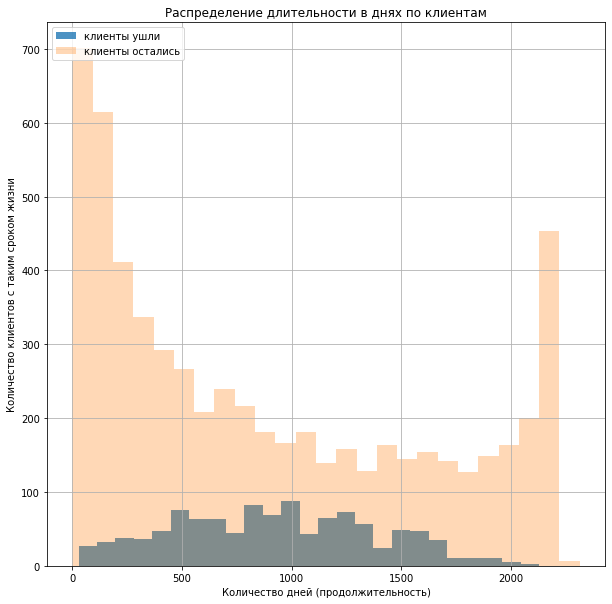

In [ ]:
plt.grid()

plt.hist(df[df['target'] == 1]['lifetime_days'], bins=25, label='клиенты ушли', alpha=0.8)
plt.hist(df[df['target'] == 0]['lifetime_days'], bins=25, label='клиенты остались', alpha=0.3)

plt.title('Распределение длительности в днях по клиентам')
plt.xlabel('Количество дней (продолжительность)')
plt.ylabel('Количество клиентов с таким сроком жизни')
plt.legend(loc='upper left');

По графику видим, что многие ушедшие клиенты ушли, после того как больше 3х лет являлись клиентами. Скорее всего, их стали не устраивать текущие услуги и, возможно, цены и они перешли к другому оператору

Также есть группа "преданных клиентов", которые являются клиентами уже более 6 лет. Также у компании много новых клиентов

Попробуем составить целевой портрет клиентов, которые уходят и которые остаются в компании - посмотрим на средний чек, какими услугами пользовался, был ли у него пенсионный статус, какой интернет использовал (оптика или DSL) и т.д:

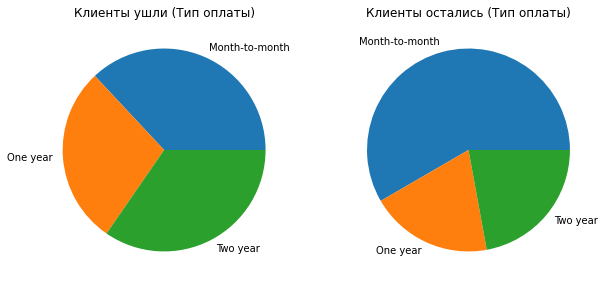

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('Type')['customerID'].count(),\
        labels = df[df['target'] == 1].groupby('Type')['customerID'].count().index)

plt.title('Клиенты ушли (Тип оплаты)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('Type')['customerID'].count(),\
        labels = df[df['target'] == 0].groupby('Type')['customerID'].count().index)

plt.title('Клиенты остались (Тип оплаты)');

Клиенты, которые ушли, имели одинаковое распределение по типу оплаты (нельзя явно выделить какой-то тип и сказать, что такой клиент с большей вероятностью уйдет)

По оставшимся клиентам явно выделяется помесячный тип оплаты (возможно - это новые клиенты (помним, что их много)

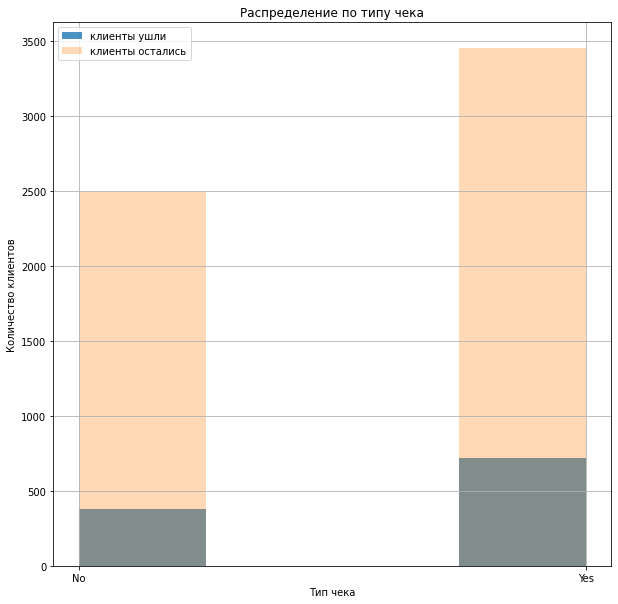

In [ ]:
plt.grid()


plt.hist(df[df['target'] == 1]['PaperlessBilling'], bins=4, label='клиенты ушли', alpha=0.8)
plt.hist(df[df['target'] == 0]['PaperlessBilling'], bins=4, label='клиенты остались', alpha=0.3)

plt.title('Распределение по типу чека')
plt.xlabel('Тип чека')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper left');

Здесь ничего интересного - одинаковое процентное распределение между первой и второй группами

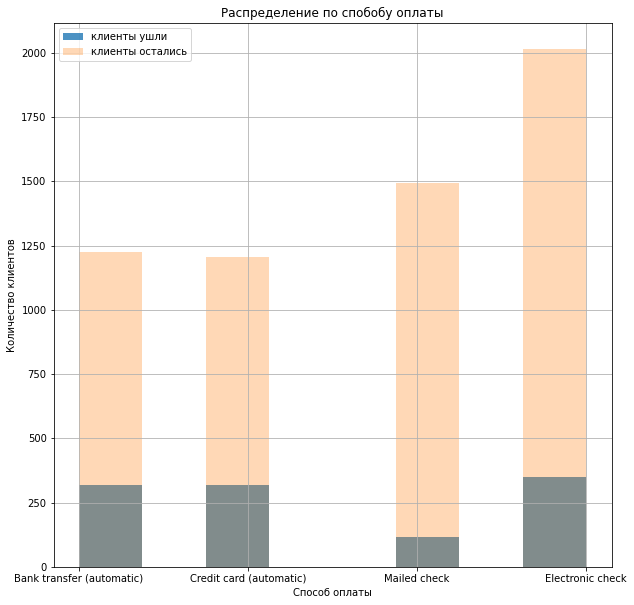

In [ ]:
plt.grid()


plt.hist(df[df['target'] == 1]['PaymentMethod'], bins=8, label='клиенты ушли', alpha=0.8)
plt.hist(df[df['target'] == 0]['PaymentMethod'], bins=8, label='клиенты остались', alpha=0.3)

plt.title('Распределение по спобобу оплаты')
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper left');

Ушедшие клиенты гораздо реже пользовались mailed check

In [ ]:
df[df['target'] == 1]['MonthlyCharges'].mean()

75.54600363306085

In [ ]:
df[df['target'] == 0]['MonthlyCharges'].mean()

62.76345506563447

Клиенты, которые ушли, в среднем ежемесячно платили на 13 долларов больше

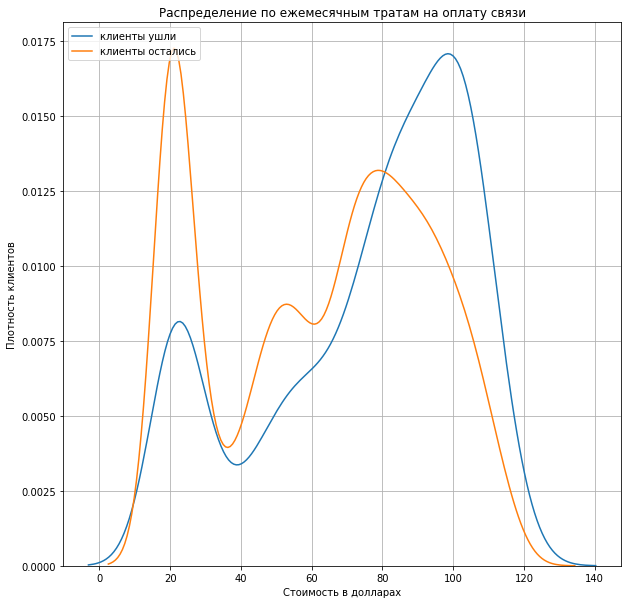

In [ ]:
plt.grid()


sns.kdeplot(df[df['target'] == 1]['MonthlyCharges'], label='клиенты ушли')
sns.kdeplot(df[df['target'] == 0]['MonthlyCharges'], label='клиенты остались')

plt.title('Распределение по ежемесячным тратам на оплату связи')
plt.xlabel('Стоимость в долларах')
plt.ylabel('Плотность клиентов')
plt.legend(loc='upper left');

Во-первых, видим, что у каждого графика есть 2 четких экстремумма (20 долларов и 80 / 100 долларов). Видимо, в зависимости от услуг (только телефон, только интернет или и то и другое) разная стоимость

Клиенты, которые ушли, чаще платили больше. Возможно, это одна из причин их ухода

In [ ]:
df[df['target'] == 1]['TotalCharges'].median()

2139.03

In [ ]:
df[df['target'] == 0]['TotalCharges'].median()

1192.8

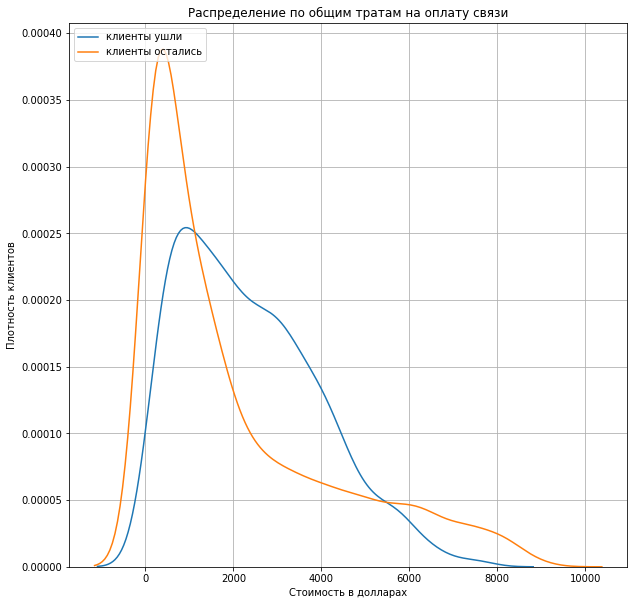

In [ ]:
plt.grid()


sns.kdeplot(df[df['target'] == 1]['TotalCharges'], label='клиенты ушли')
sns.kdeplot(df[df['target'] == 0]['TotalCharges'], label='клиенты остались')

plt.title('Распределение по общим тратам на оплату связи')
plt.xlabel('Стоимость в долларах')
plt.ylabel('Плотность клиентов')
plt.legend(loc='upper left');

Плотность распределения по общим тратам для ушедших клиентов смещена вправо относительно оставшихся клиентов

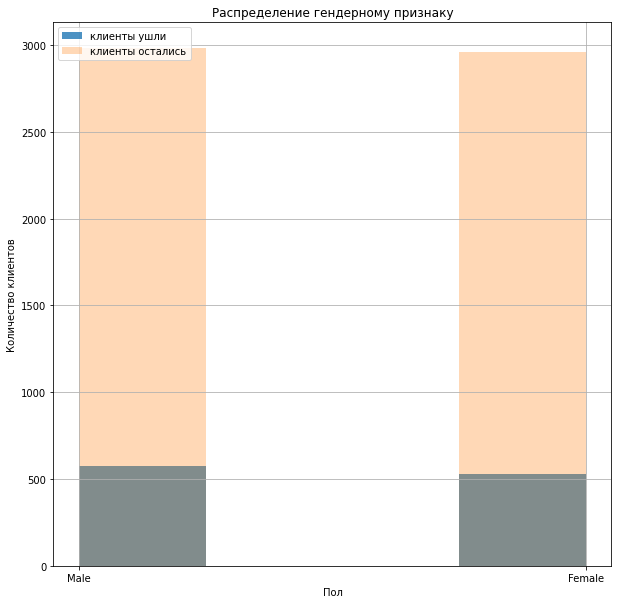

In [ ]:
plt.grid()


plt.hist(df[df['target'] == 1]['gender'], bins=4, label='клиенты ушли', alpha=0.8)
plt.hist(df[df['target'] == 0]['gender'], bins=4, label='клиенты остались', alpha=0.3)

plt.title('Распределение гендерному признаку')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper left');

Распределение м/ж одинаковое. Компания предоставляет универсальные услуги и нет выделяющейся группы по гендерному признаку

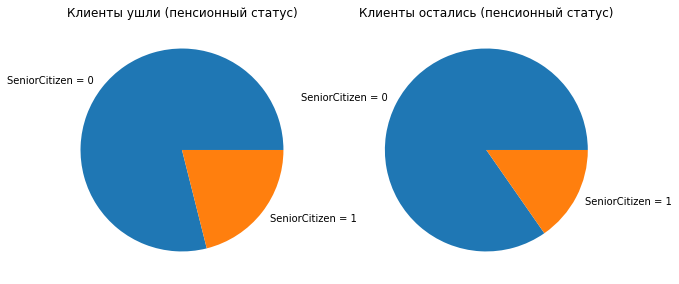

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('SeniorCitizen')['customerID'].count(),\
        labels = ['SeniorCitizen = 0', 'SeniorCitizen = 1'])

plt.title('Клиенты ушли (пенсионный статус)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('SeniorCitizen')['customerID'].count(),\
        labels = ['SeniorCitizen = 0', 'SeniorCitizen = 1'])

plt.title('Клиенты остались (пенсионный статус)');

Распределение по пенсионному статусу среди тех, кто ушел и остался одинаково практически одинаковое.

In [ ]:
df[df['target'] == 1].groupby('Partner')['customerID'].count()

Partner
No     382
Yes    719
Name: customerID, dtype: int64

In [ ]:
df[df['target'] == 0].groupby('Partner')['customerID'].count()

Partner
No     3259
Yes    2683
Name: customerID, dtype: int64

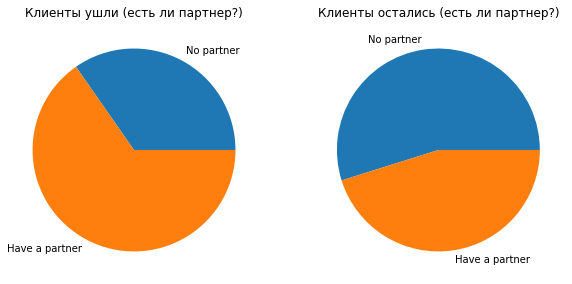

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('Partner')['customerID'].count(),\
        labels = ['No partner', 'Have a partner'])

plt.title('Клиенты ушли (есть ли партнер?)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('Partner')['customerID'].count(),\
        labels = ['No partner', 'Have a partner'])

plt.title('Клиенты остались (есть ли партнер?)');

Интересное наблюдение: среди тех клиентов, которые остались - больше одиноких (нет супруги/супруга).

In [ ]:
df[df['target'] == 1].groupby('Dependents')['customerID'].count()

Dependents
No     733
Yes    368
Name: customerID, dtype: int64

In [ ]:
df[df['target'] == 0].groupby('Dependents')['customerID'].count()

Dependents
No     4200
Yes    1742
Name: customerID, dtype: int64

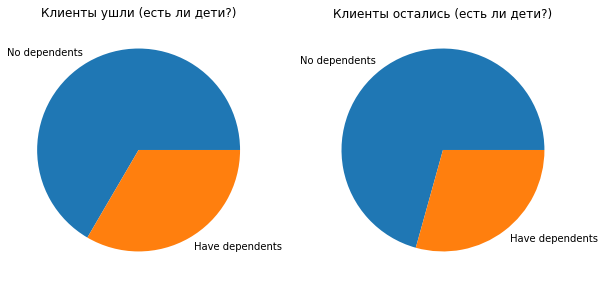

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('Dependents')['customerID'].count(),\
        labels = ['No dependents', 'Have dependents'])

plt.title('Клиенты ушли (есть ли дети?)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('Dependents')['customerID'].count(),\
        labels = ['No dependents', 'Have dependents'])

plt.title('Клиенты остались (есть ли дети?)');

Среди ушедших клиентов чуть больше имело детей. Это коррелирует с предыдущим графиком - наличие супруги/супруга

In [ ]:
df[df['target'] == 1].groupby('InternetService')['customerID'].count()

InternetService
DSL            346
Fiber optic    595
no internet    160
Name: customerID, dtype: int64

In [ ]:
df[df['target'] == 0].groupby('InternetService')['customerID'].count()

InternetService
DSL            2075
Fiber optic    2501
no internet    1366
Name: customerID, dtype: int64

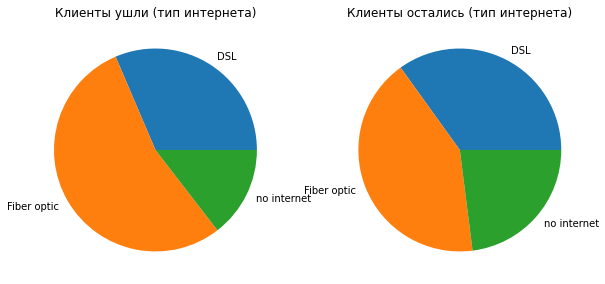

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('InternetService')['customerID'].count(),\
        labels = df[df['target'] == 1].groupby('InternetService')['customerID'].count().index)

plt.title('Клиенты ушли (тип интернета)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('InternetService')['customerID'].count(),\
        labels = df[df['target'] == 0].groupby('InternetService')['customerID'].count().index)

plt.title('Клиенты остались (тип интернета)');

Ушедшие клиенты в основном пользовались современным интернетом (fiber optic). Возможно, компания предоставляет не такой быстрый интернет, как ожидалось от данного типа соединения и поэтому клиенты уходят.
Доля DSL одинакова у обеих групп

No internet - более весомая группа у тех, кто остался. Эти люди пользуются только стационарным телефоном

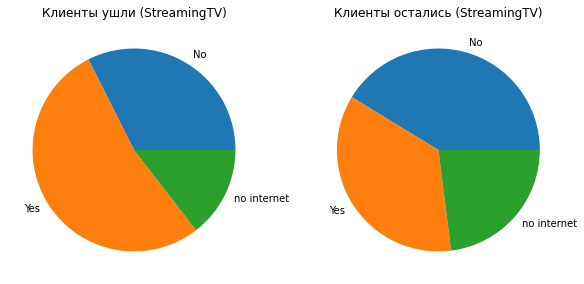

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('StreamingTV')['customerID'].count(),\
        labels = df[df['target'] == 1].groupby('StreamingTV')['customerID'].count().index)

plt.title('Клиенты ушли (StreamingTV)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('StreamingTV')['customerID'].count(),\
        labels = df[df['target'] == 0].groupby('StreamingTV')['customerID'].count().index)

plt.title('Клиенты остались (StreamingTV)');

Те клиенты, которые ушли, чаще пользовались StreamingTV, а для высокого качества важен быстрый интернет - это коррелирует с предудущим предположением, что оптиковолоконный интернет, предоставляемый компанией, не самый лучший

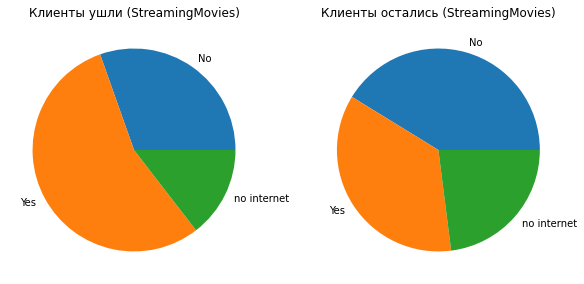

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('StreamingMovies')['customerID'].count(),\
        labels = df[df['target'] == 1].groupby('StreamingMovies')['customerID'].count().index)

plt.title('Клиенты ушли (StreamingMovies)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('StreamingMovies')['customerID'].count(),\
        labels = df[df['target'] == 0].groupby('StreamingMovies')['customerID'].count().index)

plt.title('Клиенты остались (StreamingMovies)');

Картина как и со StreamingTV

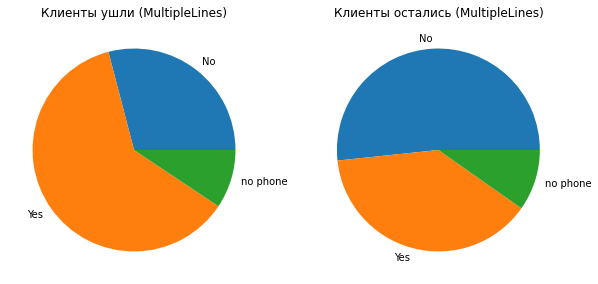

In [ ]:
plt.subplot(1,2,1)

plt.pie(\
        df[df['target'] == 1].groupby('MultipleLines')['customerID'].count(),\
        labels = df[df['target'] == 1].groupby('MultipleLines')['customerID'].count().index)

plt.title('Клиенты ушли (MultipleLines)')

plt.subplot(1,2,2)
plt.pie(\
        df[df['target'] == 0].groupby('MultipleLines')['customerID'].count(),\
        labels = df[df['target'] == 0].groupby('MultipleLines')['customerID'].count().index)

plt.title('Клиенты остались (MultipleLines)');

Вывод по анализу признаков:

В ходе анализа была цель составить портрет человека, который ушел из компани, и портрет человека, который остался клиентом

Клиенты, которые ушли:
- они пользовались большим числом услуг (стриминговое ТВ и фильмы, возможность удержания звонка (параллельная линия), чаще подключали высокоскоростной интернет) и, как следствие, платили за услуги больше (они в среднем платили ежемесячно 75 долларов против 63 долларов у клиентов, которые остались)
- это чаще семейные люди с детьми
- опираясь на длительность периода пребывания клиентом компании видим, что многие ушедшие клиенты ушли, после того как больше 3х лет являлись клиентами. Скорее всего, их стали не устраивать текущие услуги и, возможно, цены и они перешли к другому оператору

Клиенты, которые остались:
- пользуются меньшим спектром услуг и платят меньше. Если помсмотреть на медиану по ежегодной оплате, то ежегодно клиенты которые остались, платят в ДВА РАЗА меньше (медиана 1200 против 2200 у клиентов, которые ушли)
- реже пользуются интернетом
- чаще это одинокие люди (без супруги/супруга)
- есть группа "преданных клиентов", которые являются клиентами уже более 6 лет. также у компании много новых клиентов и преобладает помесячный тип оплаты

### Анализ признаков на мультиколлинеарность

Проанализируем МК численных признаков

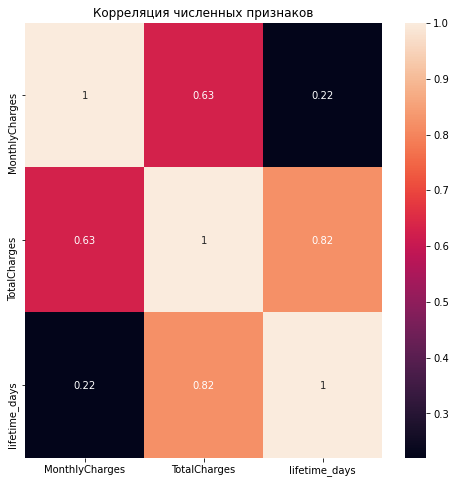

In [ ]:
plt.figure(figsize=(8,8))

sns.heatmap(df.drop(columns=['target']).corr(), annot=True)

plt.title('Корреляция численных признаков');

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Из корреляции Пирсона стоит удалить бинарный таргет(в данном случае можно рассчитать точечно бисериальную корреляцию). Также в phik можно указать interval_cols(численные признаки). Heatmap стоит сделать побольше(сейчас не читабельно)</div>

<div class="alert alert-info">
<b> Комментарий студента v.1:
    
<b> Ок, исправил) таргет удалил) точно, мы же смотрим МК признаков </div>

Ежемесячная оплата и годовая оплата сильно скореллированные признаки (это логично)

Общая сумма оплаты и длительность пребывания клиентом имеют очень высокую корреляцию (логично - чем дольше человек был клиентом, тем больше денег он заплатил)

**Вывод:**

Для линейный моделей - можно удалить столбец TotalCharges, так как он сильно скоррелирован с ежемесячной оплатой и длительностью "жизни" клиента

PHIK - Google collab reference

In [ ]:
df.describe().columns

Index(['MonthlyCharges', 'TotalCharges', 'target', 'lifetime_days'], dtype='object')

In [ ]:
df.phik_matrix(interval_cols = df.drop(columns=['target']).describe().columns)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,lifetime_days
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BeginDate,1.0,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.011268,0.050862,0.473514,0.208564,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035,0.450254,0.978521
EndDate,1.0,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,0.018274,0.090502,0.177492,0.055518,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504,1.000000,0.396342
Type,1.0,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.094015,0.634155
PaperlessBilling,1.0,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.083398,0.026799
PaymentMethod,1.0,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.214832,0.350964
MonthlyCharges,1.0,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.008175,0.304985,0.203545,0.184366,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983,0.226280,0.387727
TotalCharges,1.0,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.000000,0.135650,0.381958,0.084247,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787,0.302890,0.848337
gender,1.0,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,1.0,0.050862,0.090502,0.086231,0.242133,0.292725,0.304985,0.135650,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.086159,0.063315


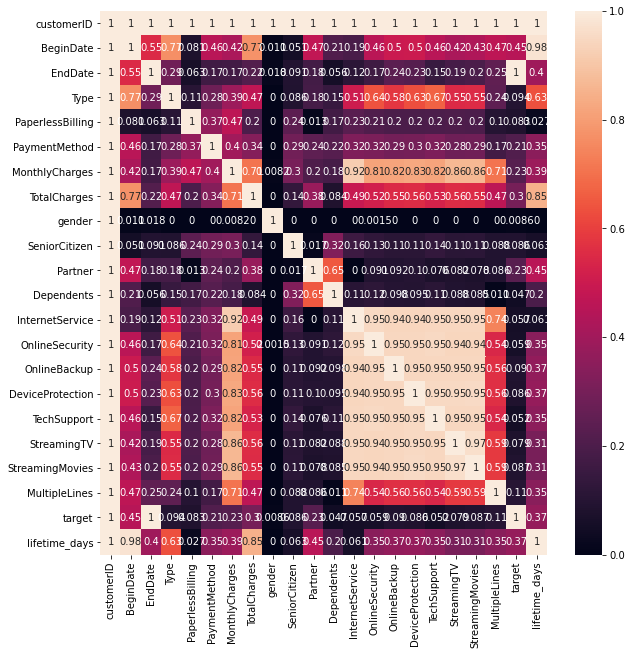

In [ ]:
sns.heatmap(df.phik_matrix(interval_cols = df.describe().columns), annot=True);

- При обучении надо будет обязательно удалить из признаков столбец EndDate, так как он имеет 100% корреляцию с таргетом и возникнет утечка данных
- высокую корреляцию имеют между собой признаки, связанные с доп услугами (интернет сервис, стриминговое тв и тд). Эти же признаки сильно коррелируют с ежемесячной стоимостью, поэтому теоретически можно удалить столбцы StreamingTV, InternetService, OnlineSecurity, onlineBackup, DeviceProtection - эти услуги отображены в ежемесяной стоимости. Можно оставить StreamingMovies, TechSupport (так как они заменят удаленные столбцы связанные с доп услугами по интернету)

Удалим столбцы CustomerID, BeginDate, EndDate, gender (от этого столбца вообще ничего не зависит)
Осатльные столбцы пока оставим, так как бустинговые модели и деревянные практически не чувствительны к мультиколлинеарности. Возможно, бустинговые или деревянные модели найдут более сложные зависимости в данных и это повысит нашу итоговую метрику

In [ ]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'target',
       'lifetime_days'],
      dtype='object')

In [ ]:
df = df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'gender'])

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Согласен с gender! </div>

In [ ]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,lifetime_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,No,DSL,No,Yes,No,No,No,No,no phone,0,31
1,One year,No,Mailed check,56.95,2071.84,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no phone,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


### Построение моделей

#### Разделение на выборки

Разделим выборку на признаки и целевой признак:

In [ ]:
features = df.drop(columns='target')
target = df['target']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=df['target'])

In [ ]:
print(f'X_train shape = {features_train.shape}')
print(f'X_test shape = {features_test.shape}')
print(f'y_train shape = {target_train.shape}')
print(f'y_test shape = {target_test.shape}')

X_train shape = (5282, 17)
X_test shape = (1761, 17)
y_train shape = (5282,)
y_test shape = (1761,)


Разделение на фичи и таргеты выполнено

Рассмотрим различные модели

#### Модель Логистическая регрессия

Предобработка числовых переменных

In [ ]:
# список числовых переменных
numeric_features = ['MonthlyCharges', 'TotalCharges', 'lifetime_days']
numeric_transformer = StandardScaler()

Предобработка категориальных переменных

In [ ]:
#категориальные признаки (general)
categorical_features = features_train.select_dtypes(include='object').columns.to_list()
print(len(categorical_features))
print(categorical_features)

14
['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [ ]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Комбинированный препроцессор для числовых и категориальных переменных

In [ ]:
#preprocessor (general)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Создание пайплайна для обучения модели (https://scikit-learn.ru/6-1-pipelines-and-composite-estimators/)

In [ ]:
pipe = make_pipeline(preprocessor, LogisticRegression(random_state=RANDOM_STATE))

In [ ]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'lifetime_days']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('logisticregression',
                 LogisticRegression(random_state=110923))])

In [ ]:
#проверка, что шаги корректные
pipe.steps[1]

('logisticregression', LogisticRegression(random_state=110923))

In [ ]:
#задаем параметры сетки
param_grid = {
    'logisticregression__penalty' : ['l2', None, 'l1', 'elasticnet'], #['l2', None, 'l1', 'elasticnet']
    'logisticregression__solver' : ['lbfgs', 'liblinear', 'saga']
}

#настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=5, #небольшой датасет - возьмем 5 фолдов
                           scoring='roc_auc', #настраиваем метрику на нашу: AUC ROC
                           n_jobs=-1
                          )

In [ ]:
%%time
#обучение модели Лог регрессия (сетки)
grid_search.fit(features_train, target_train);

CPU times: user 7.3 s, sys: 4.17 s, total: 11.5 s
Wall time: 11.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'lifetime_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'MultipleLines'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=110923))]),
             n_jobs=-1,
             param_grid={'logisticregression__penalty': ['l2', None, 'l1',
                                                         'elasticnet'],
                         'logisticregression__solver': ['lbfgs', 'liblinear',
                                                        'saga']},
             scoring='roc_auc')

In [ ]:
#print(f'Best_model: {grid_search.best_estimator_}')
print(f'Best_parametrs: {grid_search.best_params_}')
print(f'Best AUC ROC: {(grid_search.best_score_)}')

Best_parametrs: {'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best AUC ROC: 0.7683588262071022


Метрика AUC ROC получилась всего 0.77 - это ниже требуемых в задании 0.85, поэтому будем рассматривать дальше более сложные модели градиентного бустинга

Выполним анализ важжности признаков - посмотрим на коэффициенты (на веса) в модели Логистической регрессии

Для визуализации - нам потребуются названия колонок после применения энкодера

In [ ]:
X_train_lg = features_train.copy()

In [ ]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_lg[categorical_features])

# добавляем закодированные признаки в features_train_ohe
#encoder_ohe.get_feature_names_out() #позволяет получить названия колонок
X_train_lg[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_lg[categorical_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_lg = X_train_lg.drop(categorical_features, axis=1)

X_train_lg.head()

,MonthlyCharges,TotalCharges,lifetime_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_no internet,OnlineSecurity_Yes,OnlineSecurity_no internet,OnlineBackup_Yes,OnlineBackup_no internet,DeviceProtection_Yes,DeviceProtection_no internet,TechSupport_Yes,TechSupport_no internet,StreamingTV_Yes,StreamingTV_no internet,StreamingMovies_Yes,StreamingMovies_no internet,MultipleLines_Yes,MultipleLines_no phone
2322,20.45,1002.05,1492,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6846,79.55,238.65,92,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
668,45.65,228.25,153,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,75.30,1749.22,702,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,20.35,101.75,153,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


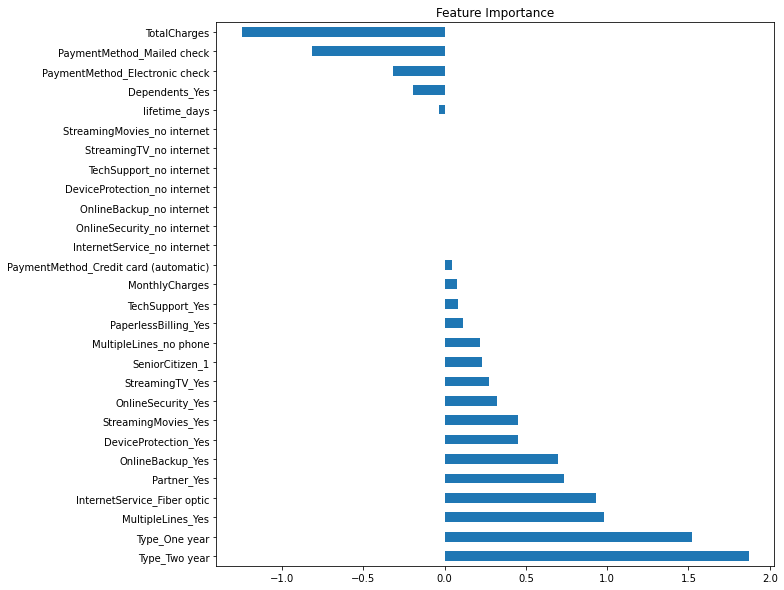

In [ ]:
importance = grid_search.best_estimator_._final_estimator.coef_[0]
#importance is a list so you can plot it.
feat_importances = pd.Series(importance, index=X_train_lg.columns)
feat_importances.nlargest(30).plot(kind='barh', title='Feature Importance');

Вывод:
- Метрика AUC ROC получилась всего 0.77 - это ниже требуемых в задании 0.85, поэтому будем рассматривать дальше более сложные модели градиентного бустинга
- Самые большие кф модель поставила перед типом оплаты (один год или два года)

#### Модель RF

In [ ]:
pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state=RANDOM_STATE))

In [ ]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'lifetime_days']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=110923))])

In [ ]:
pipe.steps[1]

('randomforestclassifier', RandomForestClassifier(random_state=110923))

In [ ]:
#задаем параметры сетки
param_grid = {
    'randomforestclassifier__n_estimators' : [50, 100, 150],
    'randomforestclassifier__max_depth' : [6, 8, 10]
}

grid_rf = RandomizedSearchCV(estimator=pipe,
                        param_distributions=param_grid,
                        cv=3,
                        n_iter=50,
                        n_jobs=-1,
                        scoring='roc_auc')

In [ ]:
%%time

grid_rf.fit(features_train, target_train)

CPU times: user 10.6 s, sys: 86.8 ms, total: 10.7 s
Wall time: 10.7 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'lifetime_days']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'MultipleLines'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=110923))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [6,
                                                                              8,
                                                                              10],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 150]},
                   scoring='roc_auc')

In [ ]:
print('Лучшие гиперпараметры: ', grid_rf.best_params_)
print('ROC_AUC:', grid_rf.best_score_)

Лучшие гиперпараметры:  {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_depth': 8}
ROC_AUC: 0.8204173773444502


Метрика 0.82 - почти достигли заданного порога в 0.85.

Посмотрим на важность признаков

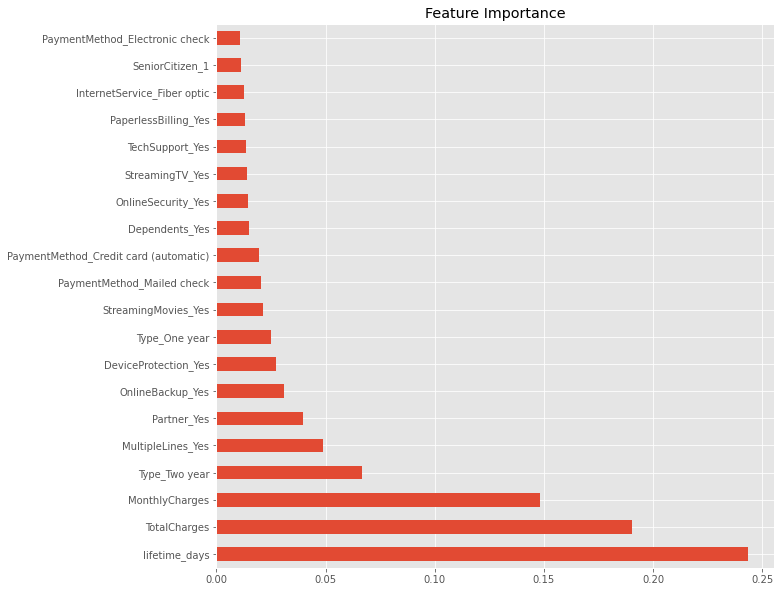

In [ ]:
plt.style.use('ggplot')

feat_importances = pd.Series(grid_rf.best_estimator_._final_estimator.feature_importances_, index=X_train_lg.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance');

Здесь важность признаков выглядит в соответствии с нашим исследовательским анализом - самые важные признаки - это длительность "жизни" клиента, общая заплаченная сумма, сумма ежемесячного платежа

Вывод:
- модель RF дала метрику AUC ROC 0.82 (ниже требуемых 0.85)
- по итогам визуализации важности признаков: самые важные признаки - это длительность "жизни" клиента, общая заплаченная сумма, сумма ежемесячного платежа

#### Модель Catboost

In [ ]:
model_cat = CatBoostClassifier()

params = {
    'max_depth' : [2, 3, 4],
    'random_seed' : [RANDOM_STATE],
    'learning_rate' : [0.5, 0.75, 1],
    'logging_level' : ['Silent']
}
grid_cat = RandomizedSearchCV(estimator=model_cat,
                        param_distributions=params,
                        cv=3,
                        n_iter=50,
                        n_jobs=-1,
                        scoring='roc_auc')

In [ ]:
%%time

grid_cat.fit(features_train, target_train,
             cat_features=categorical_features,
             plot=False)

CPU times: user 2min 29s, sys: 4.83 s, total: 2min 34s
Wall time: 3min 13s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fd48ad1ffa0>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.5, 0.75, 1],
                                        'logging_level': ['Silent'],
                                        'max_depth': [2, 3, 4],
                                        'random_seed': [110923]},
                   scoring='roc_auc')

In [ ]:
print('Лучшие гиперпараметры: ', grid_cat.best_params_)
print('ROC_AUC:', grid_cat.best_score_)

Лучшие гиперпараметры:  {'random_seed': 110923, 'max_depth': 2, 'logging_level': 'Silent', 'learning_rate': 0.5}
ROC_AUC: 0.9257049002021059


Получили AUC ROC = 0.925 > 0.85

Таким образом, выбираем итоговую модель Cat_boost с параметрами:
- макс глубина 2
- скорость обучения 0.5

Выполним визуализацию важности признаков (https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_get_feature_importance )

In [ ]:
cat_features_imp = grid_cat.best_estimator_.get_feature_importance(data=None,
                       reference_data=None,
                       #type=FeatureImportance,
                       prettified=False,
                       thread_count=-1,
                       verbose=False)
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr)

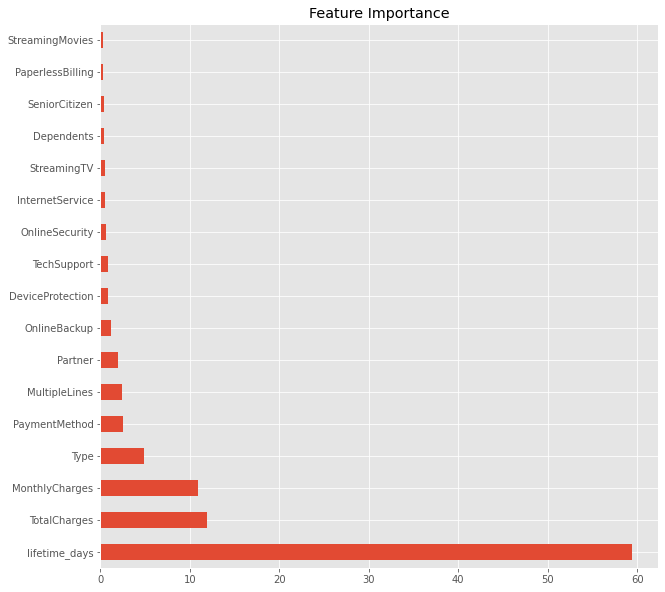

In [ ]:
plt.style.use('ggplot')

feat_importances = pd.Series(cat_features_imp, index=features_train.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance');

Вывод:
- модель CatBoost дала самую высокую метрику 0.925. Таким образом, выбираем итоговую модель Cat_boost с параметрами: макс глубина 2, скорость обучения 0.5
- самые важные признаки как и в RF - это длительность "жизни" клиента, общая заплаченная сумма, сумма ежемесячного платежа. Влияние остальных признаков сильно ниже, чем в том же RF

### Проверка финальной модели на тестовой выборке

Итоговая модель Cat_boost с параметрами: макс глубина 2, скорость обучения 0.5

In [ ]:
best_model = grid_cat.best_estimator_
print(best_model)

In [ ]:
print(grid_cat.best_params_)

{'random_seed': 110923, 'max_depth': 2, 'logging_level': 'Silent', 'learning_rate': 0.5}


In [ ]:
print(f'FINAL Test AUC ROC = {roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])}')

FINAL Test AUC ROC = 0.9294714303193442


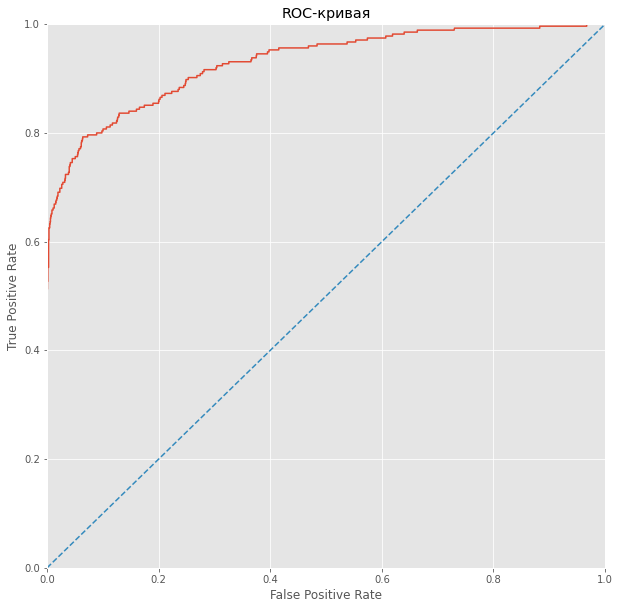

Площаль под ROC-кривой: 0.9294714303193442


In [ ]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площаль под ROC-кривой:', auc_roc)

In [ ]:
y_score = best_model.predict_proba(features_test)[:, 1]
answer = pd.DataFrame(y_score, columns=['y_score'])
answer['y_pred'] = (answer['y_score'] >= 0.5) * 1
answer['y_true'] = target_test.values
answer.head()

,y_score,y_pred,y_true
0,0.011367,0,1
1,0.079299,0,0
2,0.583163,1,1
3,0.025073,0,0
4,0.006200,0,0


In [ ]:
((answer['y_pred'] == answer['y_true'])*1).mean()

0.9375354911981828

In [ ]:
accuracy_score(target_test, best_model.predict(features_test))

0.9375354911981828

Точность модели 93.75%

Построим матрицу ошибок:

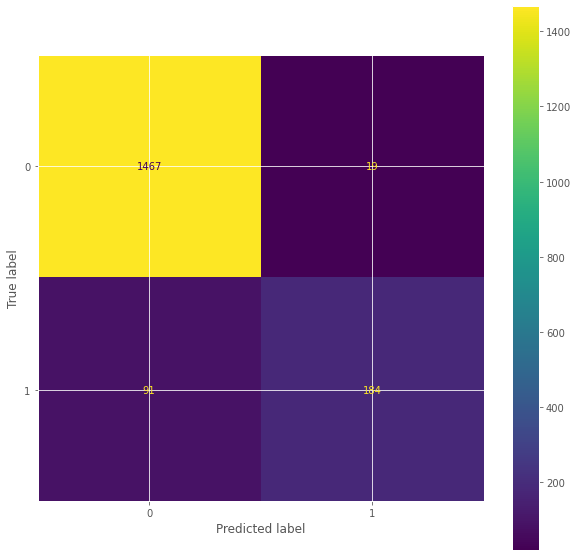

In [ ]:
cm = confusion_matrix(target_test, best_model.predict(features_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)

disp.plot();

In [ ]:
recall_final_model = recall_score(target_test, best_model.predict(features_test))

print(f'Recall score for final model = {recall_final_model}')

Recall score for final model = 0.6690909090909091


Почти 67% клиентов, которые ушли, модель классифицировала верно

In [ ]:
print(f'Precision for final model = {precision_score(target_test, best_model.predict(features_test))}')

Precision for final model = 0.9064039408866995


Точность определения уйдет клиент или нет составила больше 90%

Вывод:
- значение метрики итоговой модели на тестовой выборке составило 0.93
- почти 67% клиентов, которые ушли, модель классифицировала верно
- точность определения уйдет клиент или нет составила больше 90%.

Таким образом, задачу по достижению метрики AUC ROC больше 0.85 мы решилии. Наша модель имеет высокую точность - больше 90%, а это значит если модель предскажет, что клиент скорее всего уйдет, то с вероятностью 90% так и будет, поэтому в отношении такого клиента надо принимать срочные шаги по удержанию (новые условия, скидки, доп усплуги, а может быть просто небольшой подарок или сбор обратной связи - что ему хотелось бы улучшить или что не устраивает)

## Отчет по решению (часть 3)

### Какие пункты плана были выполнены, а какие — нет. Почему?

Исходный план, указанный в пункте 1.4, выглядел следующим образом:

1) выполнить предобработку данных (поменять типы данных где это требуется), выделить целевой признак на основе EndDate, объединить таблицы на основе CustomerID

2) выполнить исследовательский анализ данных

3) подготовка данных к обучению моделей (выделение признаков, возможно создание новых доп признаков, проверка на корреляцию с таргетом и тд, деление выборки на обучающую и тестовую)

4) обучение нескольких моделей (минимум двух): построение пайплайна обработки фичей, подбор гиперпараметров, проведение кроссвалидации и выбор итоговой модели, лучше всего подходящей по выбранной в задаче метрике (AUC ROC)

5) проверка выбраной (лучшей) модели на тестовой выборке: получение итоговой метрики, анализ важности признаков, построение матрицы ошибок и ROC кривой

6) подготовка итогового отчета

**Результат**

В части 2 были выполнены все части плана (кроме 6). Исходный план был достаточно подробным и похож на выполнение предыдущих проектов в процессе учебы, поэтому здесь отклонений от первоначального плана не произошло - все пункты были ожидаемыми

### Какие трудности возникли и как вы их преодолели?

Пожалуй, самой трудной частью было реализовать пайплайн обработки данных для модели и потом совместить это с перебором гиперпараметров и кроссвалидацией. В предыдущих проектах я подготавливал признаки отдельно (кодировка категориальных, масштабирование) и только после этого подавал их в модель. И здесь при использовании кроссвалидации в GS (GridSearchCV) или RandomizedSearchCV возникала утечка данных при кроссвалидации. В данном выпускном проекте я освоил pipeline и устранил этот момент. Также приятным бонусом было то, что фичи после прохождения pipeline оставались неизменными! т.е. в старом способе, где заранее обрабатывал фичи 0 приходилось создавать копию (что-то в стиле X_train_ridge = X_train.copy()) и далее преобразовывать X_train_ridge и подавать на вход в модель. А исходные X_train сохранфл неизменными, чтобы использовать в другиз моделях. В данном проекте такой роблемы с создаванием копий не было

Новым также был анализ важности признаков. Здесь разобрался с feature_importance для RF и Catboost)

### Какие ключевые шаги в решении задачи вы выделили?

Сначала необходимо понять задачу и запрос от бизнеса: что хотим в итоге получить и на что повлиять? Далее идет выбор метрики модели, по которой мы будем измерять качество

Затем сбор данных (у нас были даны 3 датасета)

Далее обзор данных, предобработка, исследовательский анализ данных и построение ML моделей для решения задачи, выбор лучшей модели по заданным параметрам (скорость работы, качество и тд) и подготовка финального отчета

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

В соответствии с пунктом работы 2.3:

Для обучения модели использовались все исходные признакми, кроме
- CustomerID,
- BeginDate,
- EndDate,
- gender (от этого столбца вообще ничего не зависит)

Остальные столбцы оставил, так как бустинговые модели и деревянные практически не чувствительны к мультиколлинеарности. В итоге, бустинговые и деревянные модели нашли более сложные зависимости в данных и это повысило нашу итоговую метрику AUC ROC по сравнению с использованием Логистической регресии с регуляризацией

Предобработка описана в пунке 2.1:
- Поменяли типы данных, где это было неоходимо (SeniorCitizen -> object, TotalCharges -> float, даты -> datetime
- Заменили No в столбце EndDate датой выгрузки (01.02.2020) и далее сформировали целевой признак target
- заполнили пропуски в столбце totalcharges нулями (11 пропусков - новые клиенты)
- создали новый столбец lifetime_day (длительность "жизни клиента" в днях)
- объединили датасеты в один, опираясь на CustomerID
- не все клиенты пользовались одновременно телефоном и интернетом, поэтому заполнил пропуски в столбцах заглушками - 'no phone' and 'no internet'
- удалили лишние для обучения модели признаки (CustomerID BeginDate, EndDate,gender)


### Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Итоговой моделью была выбрана модель градиентого бустинга CatBoost с параметрами: максимальная глубина 2, learning rate 0.5, random_state = 110923

На тестовой выборке итоговая модель показала следующие результаты:

- значение метрики итоговой модели на тестовой выборке составило AUC ROC = 0.93
- почти 67% клиентов, которые ушли, модель классифицировала верно
- точность определения уйдет клиент или нет составила больше 90%.

Таким образом, задачу по достижению метрики AUC ROC больше 0.85 мы решили. Наша итоговая модель имеет высокую точность - больше 90%, а это значит если модель предскажет, что клиент скорее всего уйдет, то с вероятностью 90% так и будет, поэтому в отношении такого клиента надо принимать срочные шаги по удержанию (новые условия, скидки, доп усплуги, а может быть просто небольшой подарок или сбор обратной связи - что ему хотелось бы улучшить или что не устраивает)

Итого: такую модель могут использовать в отделе по работе с клиентами, тем самым вовремя постараться удержать клиента путем различных маркетинговых предложений

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;background:rgb(185, 176, 207)">
<b>Совсем итоговый комментарий, персональная обратная связь и рекомендации:
</b>Молодец, хорошая работа! Поздравляю с окончанием обучения!Что можно улучшить:<br>
    1. PEP-8(особенно импорты)<br>
    2. Старайся избегать дублирования кода, heatmap лучше сделать покрупнее(коэффициенты не читабельны)<br>
    3. В phik стоит явно указывать interval_cols(численные ризнаки), достаточно одной матрицы для всех признаков<br>
    4. Для категориальных признаков советую использовать sns.countplot с параметром hue(также можно посмотреть pairplot для численных) <br>
    5. Советую подробнее изучить  <a href = "https://habr.com/ru/articles/712080/">пайпланы</a><br>
    6. Можно также добавить проверку гипотез о равенстве средних для численных признаков<br>
    7. Почитай про <a href = "https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/">Overfitting и Underfitting</a><br>
    8. Советую почитать про <a href = "https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html"?>BayesSearchCV</a><br>
    9. Советую почитать про уменьшение размерности в ML<br>
    10. Советую почитать про ансамбли моделей <a href = "https://habr.com/ru/post/561732/">моделей</a><br>
    11. Стоит подробнее почитать про <a href = "https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b">мультиколлинеарность</a><br>
    12. Можешь почитать про feature selection<a href = "https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/">Тык</a><br>
    13. Советую подробнее изучить <a href = "https://habr.com/ru/articles/594077/">кэтбуст</a> со встроенными методами <br>
    14. По поводу утечек можешь почитать <a href = "https://machinelearningmastery.com/data-preparation-without-data-leakage/">тут</a><br>
    15. Для анализа важности признаков советую использовать <a href="https://shap.readthedocs.io/en/latest/">SHAP</a><br>
    16.Для бустинговых моделей лучше использовать встроенные кодировщики. <br>        После второго вебинара скину файл с полезными ссылками, возможно найдешь для себя что-нибудь интересное и полезное). <br> </div>